<a href="https://colab.research.google.com/github/janmejaybhoi/GradCam_Visualization/blob/main/GradCam_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scene Classification with GradCam Visualization


This notebook will examine behaviors of a visual explanation methods of deep learning model.
The model will train classifying to **_6 classes (buildings, forest, glacier, mountain, sea, street)_** for each images using this datasets.
The architecture of the model is a **self prepared ResNet18_** .
Visual explanation methods that will be examined are

\- **_Grad-CAM https://arxiv.org/abs/1610.02391_**  

**Why this is Useful? **

* *To help deep learning practitioners visually debug their models and properly understand where it’s “looking” in an image, Selvaraju et al. created Gradient-weighted Class Activation Mapping, or more simply, Grad-CAM*

* *Grad-CAM uses the gradients of any target concept (say logits for “dog” or even a caption), flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.*


### Using Kaggle API to download dataset into Colab Environment

In [2]:
!pip install -q kaggle

In [3]:
# just use your kaggle kernel (Go to your kaggle account setting and Download kaggle API)
from google.colab import files
files.upload()           

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"janmejaybhoi","key":"6cdf252d44b3db77a67e30fff01bf8a0"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d puneet6060/intel-image-classification

100% 345M/346M [00:02<00:00, 131MB/s]
100% 346M/346M [00:02<00:00, 131MB/s]


In [ ]:
!unzip /content/intel-image-classification

##  Import necessary libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from random import sample
from IPython.display import display
import os
import PIL


## Read Data


In [9]:
train = {}
test = {}

path = "/content/intel-image-classification"

# Make dictionary storing images for each category under train data.
path_train = os.path.join(path, "seg_train/seg_train")
for i in os.listdir(path_train):
    train[i] = os.listdir(os.path.join(path_train, i))

# Make dictionary storing images for each category under test data.
path_test = os.path.join(path, "seg_test/seg_test")
for i in os.listdir(path_test):
    test[i] = os.listdir(os.path.join(path_test, i))

## Explore data

In [10]:
# View the number of images in the entire training and testing datasets respectively.
len_train = np.concatenate(list(train.values())).shape[0]
len_test = np.concatenate(list(test.values())).shape[0]

print("Number of images in training data : {}".format(len_train))
print("Number of images in testing data : {}".format(len_test))

Number of images in training data : 14034
Number of images in testing data : 3000


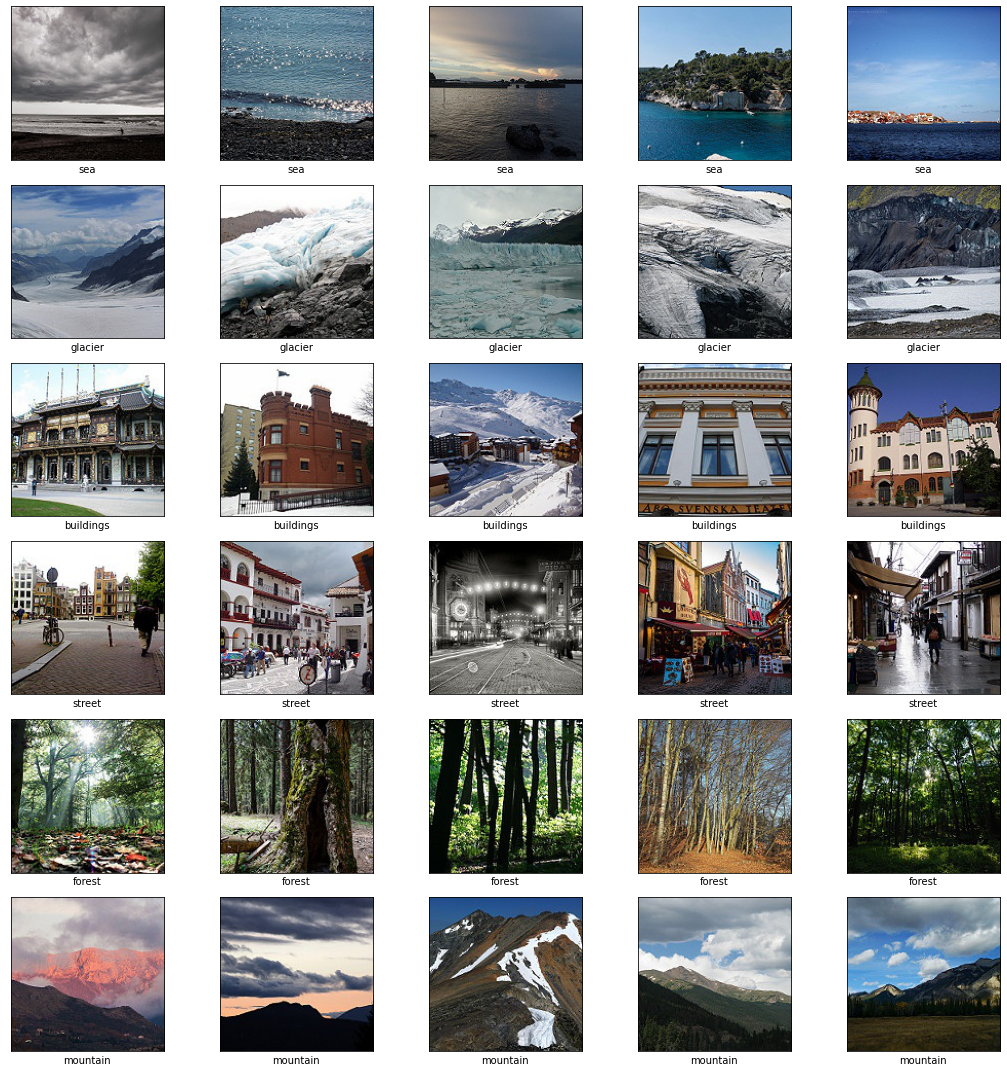

In [11]:
# Randomly display 5 images under each of the 6 categories from the training data.
# You will see different images each time.
fig, axs = plt.subplots(6, 5, figsize = (15, 15))
for i, item in enumerate(os.listdir(path_train)):
    images = sample(train[item], 5)
    
    for j, image in enumerate(images):
        img = PIL.Image.open(os.path.join(path_train, item, image))
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = item, xticks = [], yticks = [])

fig.tight_layout()

In [12]:
# View the number of images in each of the 6 categories in the training data.
for item in train.keys():
    print(item, len(train[item]))

sea 2274
glacier 2404
buildings 2191
street 2382
forest 2271
mountain 2512


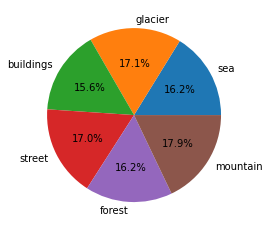

In [14]:
# Make a pie-chart to visualize the percentage contribution of each category.
# This is often useful when you want your dataset to be balanced.
fig, ax = plt.subplots()
ax.pie(
    [len(train[item]) for item in train],
    labels = train.keys(),
    autopct = "%1.1f%%"
)
fig.show()

## Augment data

In [15]:
# Create an Image Generator and specify the type of data augmentation you want to apply.
# Here we go with zooming, flipping (horizontally and vertically), and rescaling.
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale=1./255
)

# For test data we only rescale the data.
# Never augment test data!!!
test_datagen = ImageDataGenerator(rescale=1./255)

## Create data generator

In [16]:
# Create a generator for the images. 
# This will make images (including augmented ones) start flowing from the directory to the model.
# Note that augmented images are not stored along with the original images. The process happens in memory.

# Train generator
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Develop Neural Network Architecture

In [17]:
# This function implements a resnet block.
# You can use a different architecture if you like.
def res_block(X, filter, stage):
  
    # Convolutional_block
    X_copy = X

    f1 , f2, f3 = filter
    
    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = MaxPool2D((2,2))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


    # Short path
    X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
    X_copy = MaxPool2D((2,2))(X_copy)
    X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

    # ADD
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    # Identity Block 1
    X_copy = X
    

    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

    # ADD
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    # Identity Block 2
    X_copy = X


    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

    # ADD
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    return X

In [18]:
# Based on the defined resnet block, construct the neural network.

input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1- stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage
X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage
X = res_block(X, filter= [256,256,1024], stage= 4)

# 5- stage
X = res_block(X, filter= [512,512,2048], stage= 5)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dropout(0.4)(X)
X = Dense(6, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

# Build model.
model = Model(
    inputs= X_input, 
    outputs = X, 
    name = 'Resnet18'
)

# Check out model summary.
model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

## Compile model

In [19]:
# Compile the model
model.compile(
    optimizer = "adam", 
    loss = "categorical_crossentropy", 
    metrics = ["accuracy"]
)

## Specify callbacks

In [20]:
# Use early stopping to exit training if there is no improvement even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor = 'loss', 
    mode = 'min', 
    verbose = 1, 
    patience = 15
)

# Save the best model with lower validation loss
checkpointer = ModelCheckpoint(
    filepath = "weights.hdf5", 
    verbose = 1, 
    save_best_only = True
)

## Model training

In [22]:
# Finally, fit the neural network model to the data.
# Here we use 1 epoch for demonstration.
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = train_generator.n // 32, 
    epochs = 5,             
    callbacks = [
        checkpointer, 
        earlystopping
    ]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
438/438 [==============================] - 180s 412ms/step - loss: 0.8367 - accuracy: 0.6858
Epoch 2/5
438/438 [==============================] - 180s 411ms/step - loss: 0.7321 - accuracy: 0.7325
Epoch 3/5
438/438 [==============================] - 180s 411ms/step - loss: 0.6380 - accuracy: 0.7719
Epoch 4/5
438/438 [==============================] - 181s 412ms/step - loss: 0.6049 - accuracy: 0.7787
Epoch 5/5
438/438 [==============================] - 180s 411ms/step - loss: 0.5641 - accuracy: 0.7992


## Model evaluation

In [23]:
# Evaluate the performance of the model
evaluate = model.evaluate_generator(
    test_generator, 
    steps = test_generator.n // 32, 
    verbose = 1
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


93/93 [==============================] - 7s 66ms/step - loss: 1.0486 - accuracy: 0.6116


In [24]:
# Assign label names to the corresponding indexes
labels = {
    0: 'buildings', 
    1: 'forest', 
    2: 'glacier', 
    3: 'mountain', 
    4: 'sea', 
    5: 'street'
}

In [25]:
# Load images and their predictions 

prediction = []
original = []
image = []
count = 0
for i in os.listdir(path_test):
    for item in os.listdir(os.path.join(path_test, i)):
        # code to open the image
        img= PIL.Image.open(os.path.join(path_test, i, item))
        # resizing the image to (256,256)
        img = img.resize((256, 256))
        # appending image to the image list
        image.append(img)
        # converting image to array
        img = np.asarray(img, dtype = np.float32)
        # normalizing the image
        img = img / 255
        # reshaping the image into a 4D array
        img = img.reshape(-1, 256, 256, 3)
        # making prediction of the model
        predict = model.predict(img)
        # getting the index corresponding to the highest value in the prediction
        predict = np.argmax(predict)
        # appending the predicted class to the list
        prediction.append(labels[predict])
        # appending original class to the list
        original.append(i)

In [27]:
# Get the test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.6333333333333333


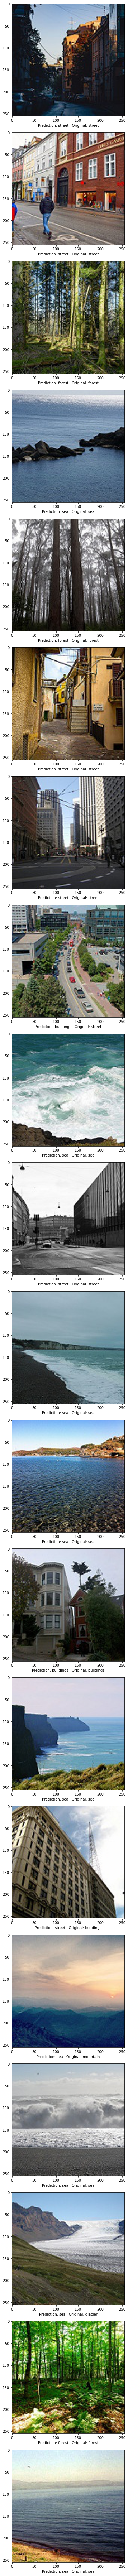

In [28]:
# Visualize the results at random
fig = plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0, len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
    
fig.tight_layout()
plt.show()

In [29]:
# Check out the Classification Report 
print(classification_report(np.asarray(prediction), np.asarray(original)))

# Based on these values, you can try t improve your model.
# For the sake of simplicity, hyperparameter tuning and model improvement was not done.

              precision    recall  f1-score   support

   buildings       0.79      0.68      0.73       510
      forest       0.85      0.93      0.89       434
     glacier       0.22      0.88      0.35       137
    mountain       0.25      0.73      0.38       183
         sea       0.94      0.41      0.57      1152
      street       0.84      0.72      0.77       584

    accuracy                           0.63      3000
   macro avg       0.65      0.72      0.62      3000
weighted avg       0.81      0.63      0.66      3000



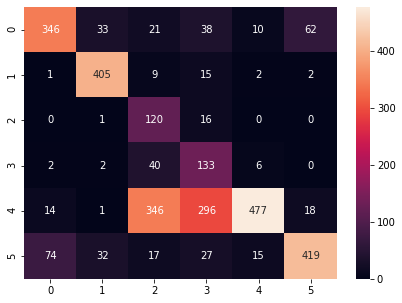

In [30]:
# View the 6x6 confusion matrix
plt.figure(figsize = (7, 5))
cm = confusion_matrix(np.asarray(prediction), np.asarray(original))
sns.heatmap(
    cm, 
    annot = True, 
    fmt = "d"
)
plt.show()

## Grad Cam Visualization

In [31]:
def grad_cam(img):
    # Convert the image to array of type float32
    img = np.asarray(img, dtype = np.float32)

    # Reshape the image from (256,256,3) to (1,256,256,3)
    img = img.reshape(-1, 256, 256, 3)
    img_scaled = img / 255

    # Name of the average pooling layer and dense final (you can see these names in the model summary)
    classification_layers = ["Averagea_Pooling", "Dense_final"]

    # Last convolutional layer in the model
    final_conv = model.get_layer("res_5_identity_2_c")

    # Create a model with original model inputs and the last conv_layer as the output
    final_conv_model = keras.Model(model.inputs, final_conv.output)

    # Then we create the input for classification layer, which is the output of last conv layer
    # In our case, output produced by the conv layer is of the shape (1,3,3,2048) 
    # Since the classification input needs the features as input, we ignore the batch dimension

    classification_input = keras.Input(shape = final_conv.output.shape[1:])

    # We iterate through the classification layers, to get the final layer and then append 
    # the layer as the output layer to the classification model.
    temp = classification_input
    for layer in classification_layers:
        temp = model.get_layer(layer)(temp)
    
    classification_model = keras.Model(classification_input, temp)


    # We use gradient tape to monitor the 'final_conv_output' to retrive the gradients
    # corresponding to the predicted class
    with tf.GradientTape() as tape:
        # Pass the image through the base model and get the feature map 
        final_conv_output = final_conv_model(img_scaled)

        # Assign gradient tape to monitor the conv_output
        tape.watch(final_conv_output)
      
        # Pass the feature map through the classification model and use argmax to get the 
        # index of the predicted class and then use the index to get the value produced by final
        # layer for that class
        prediction = classification_model(final_conv_output)

        predicted_class = tf.argmax(prediction[0][0][0])

        predicted_class_value = prediction[:,:,:,predicted_class]
  
    # Get the gradient corresponding to the predicted class based on feature map.
    # which is of shape (1,3,3,2048)
    gradient = tape.gradient(predicted_class_value, final_conv_output)

    # Since we need the filter values (2048), we reduce the other dimensions, 
    # which would result in a shape of (2048,)
    gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))

    # We then convert the feature map produced by last conv layer(1,6,6,1536) to (6,6,1536)
    final_conv_output = final_conv_output.numpy()[0]

    gradient_channels = gradient_channels.numpy()

    # We multiply the filters in the feature map produced by final conv layer by the 
    # filter values that are used to get the predicted class. By doing this we inrease the
    # value of areas that helped in making the prediction and lower the vlaue of areas, that 
    # did not contribute towards the final prediction
    for i in range(gradient_channels.shape[-1]):
        final_conv_output[:, :, i] *= gradient_channels[i]

    # We take the mean accross the channels to get the feature map
    heatmap = np.mean(final_conv_output, axis=-1)

    # Normalizing the heat map between 0 and 1, to visualize it
    heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

    # Rescaling and converting the type to int
    heatmap = np.uint8(255 * heatmap_normalized )

    # Create the colormap
    color_map = plt.cm.get_cmap('jet')

    # get only the rb features from the heatmap
    color_map = color_map(np.arange(256))[:, :3]
    heatmap = color_map[heatmap]

    # convert the array to image, resize the image and then convert to array
    heatmap = keras.preprocessing.image.array_to_img(heatmap)
    heatmap = heatmap.resize((256, 256))
    heatmap = np.asarray(heatmap, dtype = np.float32)

    # Add the heatmap on top of the original image
    final_img = heatmap * 0.4 + img[0]
    final_img = keras.preprocessing.image.array_to_img(final_img)

    return final_img, heatmap_normalized


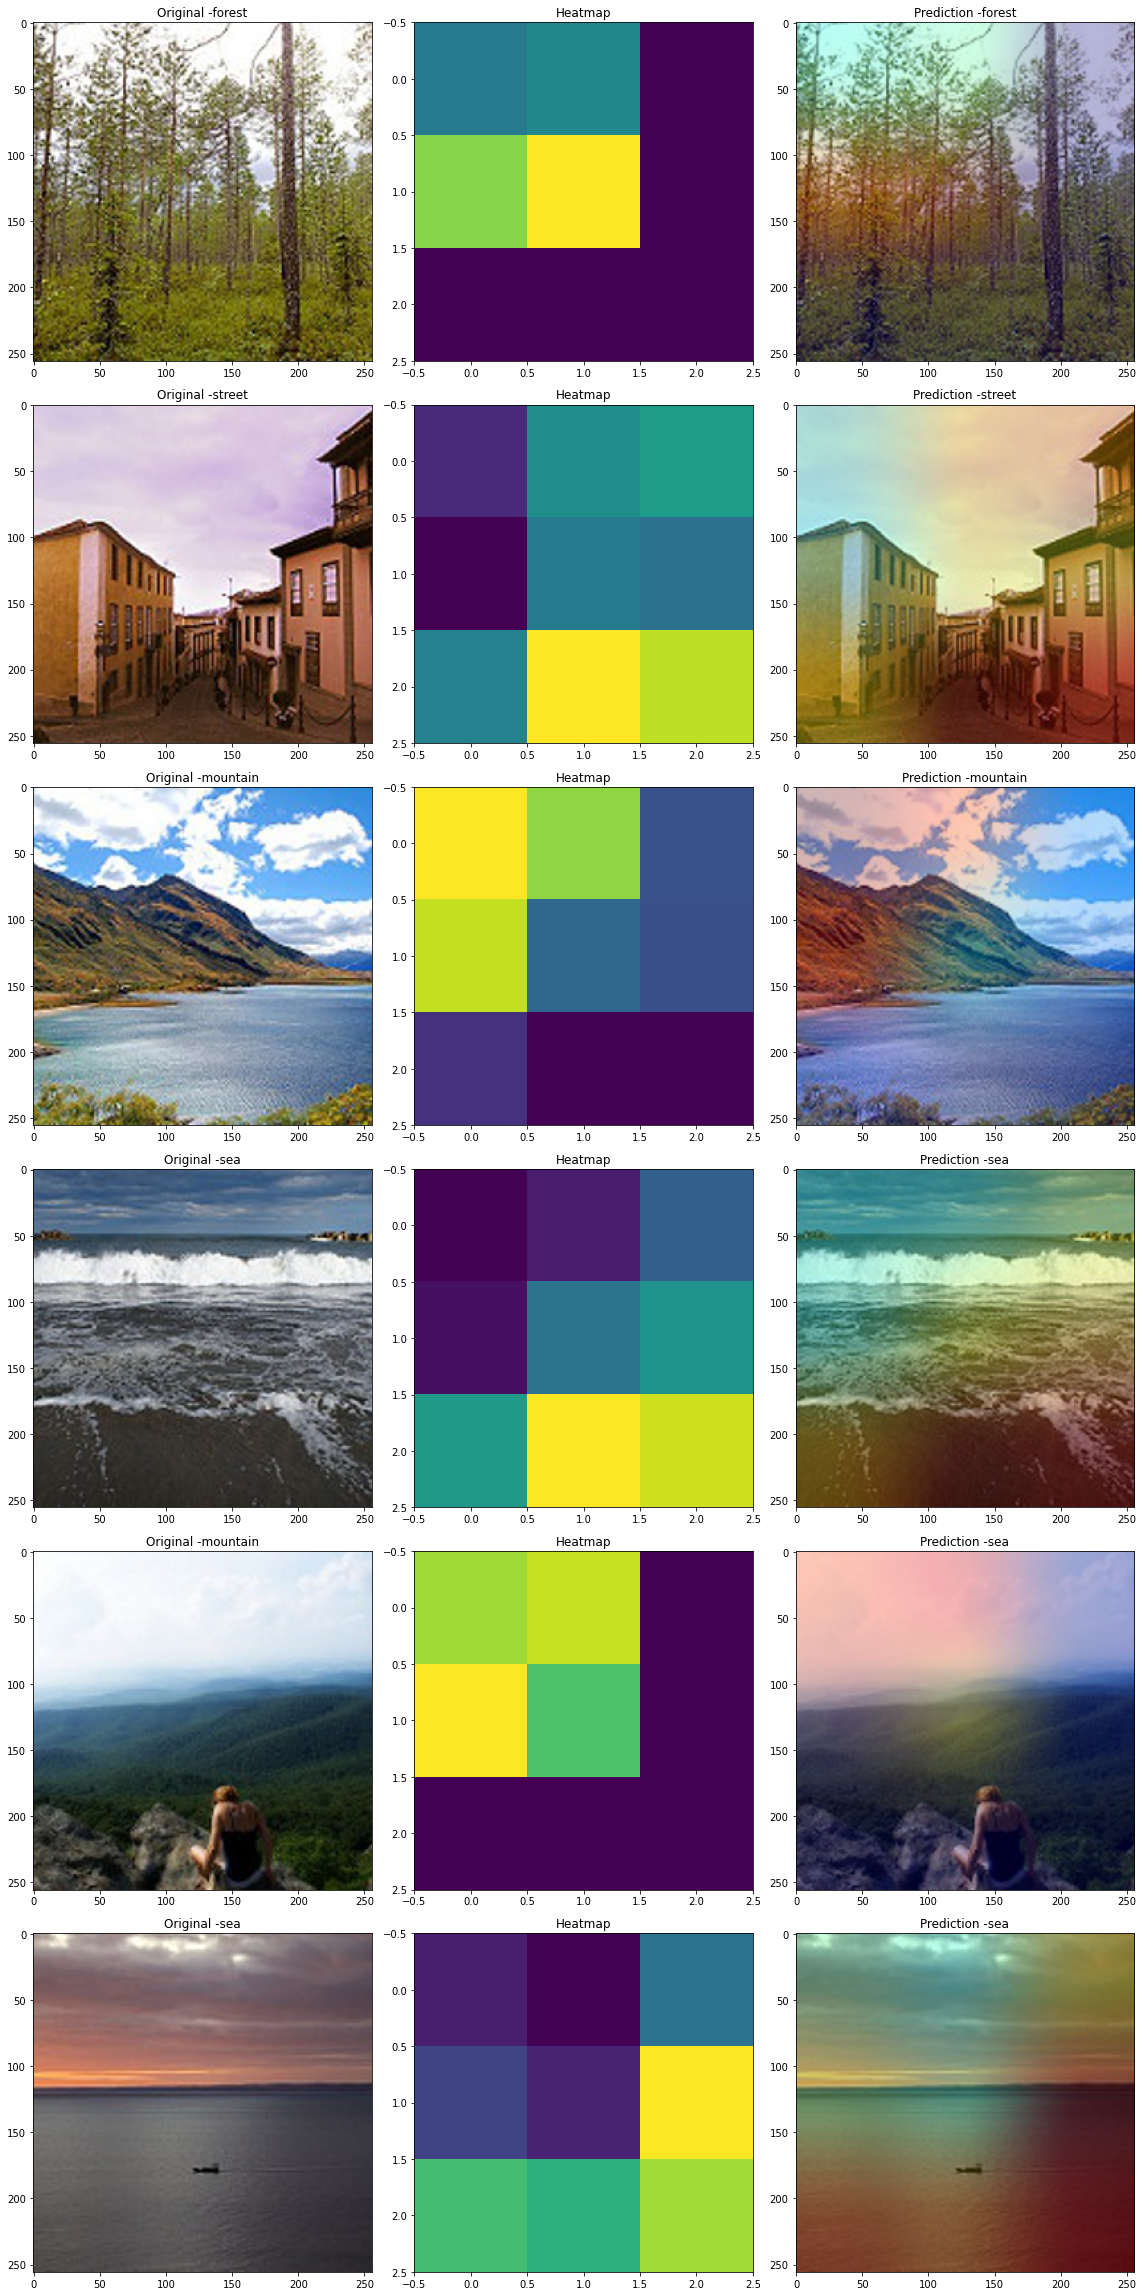

In [32]:
# Visualize the images in the dataset
fig, axs = plt.subplots(6,3, figsize = (16,32))
count = 0
for _ in range(6):
    i = random.randint(0, len(image))
    gradcam, heatmap = grad_cam(image[i])
    axs[count][0].title.set_text("Original -" + original[i])
    axs[count][0].imshow(image[i])
    axs[count][1].title.set_text("Heatmap") 
    axs[count][1].imshow(heatmap)
    axs[count][2].title.set_text("Prediction -" + prediction[i]) 
    axs[count][2].imshow(gradcam)  
    count += 1

fig.tight_layout()

# Future Work
To implement and visualize class activation map with Grad-CAM ++ and Score-CAM

\- **_Grad-CAM++ https://arxiv.org/abs/1710.11063_**  
\- **_Score-CAM https://arxiv.org/abs/1910.01279_**